# Pràctica 2 - Classificació

## Objectius

Els objectius d'aquesta pràctica són:
  
* Aplicar models de classificació, ficant l'èmfasi en:
    1. Aplicar diferents classificadors (regressor logístic i svm) i entendre les millores d'aplicar kernels.
    2. Avaluar correctament l'error del model 
    3. Visualitzar les dades i el model resultant


* Ésser capaç d'aplicar tècniques de classificació en casos reals

* Validar els resultats en dades reals

* Fomentar la capacitat per presentar resultats tècnics d'aprenentatge computacional de forma adequada davant altres persones

## Base de dades

|	7	|	GA\*07-0000	|https://www.kaggle.com/c/titanic/data	|

# Apartat (B): Classificació Numèrica (6pts)

Per a aquest primer apartat, s'analitzarà els tipus d'atributs que es tenen i, si no està estipulat, **caldrà fixar quin és l'atribut objectiu a classificar de tots els que hi ha a la base de dades**.
Expliqueu a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.

Treballarem varis aspectes de la classificació:

1. EDA (exploratory data analysis)
2. Preprocessing (normalitzation, outlier removal, feature selection..)
3. Model Selection
4. Crossvalidation
5. Metric Analysis
6. Hyperparameter Search

### 1. EDA (exploratory data analysis)

Igual com a la pràctica anterior, exploreu i visualitzeu com és la base de dades que teniu assignada.

**Preguntes:**
* Quants atributs té la vostra base de dades?
* Quin tipus d'atributs tens? (Númerics, temporals, categorics, binaris...)
* Com es el target, quantes categories diferents existeixen?
* Podeu veure alguna correlació entre X i y?
* Estan balancejades les etiquetes (distribució similar entre categories)? Creus que pot afectar a la classificació la seva distribució?

Inicialment carreguem el fitxer amb la base de dades.

In [86]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats

# Carreguem el dataset
dataset = pd.read_csv('train.csv', header=0, delimiter=',')
data = dataset.values

print("Dimensionalitat de la BBDD:", dataset.shape)

Dimensionalitat de la BBDD: (891, 12)


Comprovació de la validesa de les dades.

In [87]:
print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())

Per comptar el nombre de valors no existents:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Mirem les estadístiques principals en en una taula per veure les dades d'una manera més numérica i no tan gràfica.

In [89]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Utilitzem pairplot per observar com es relacionen les dades restants.

<IPython.core.display.Javascript object>


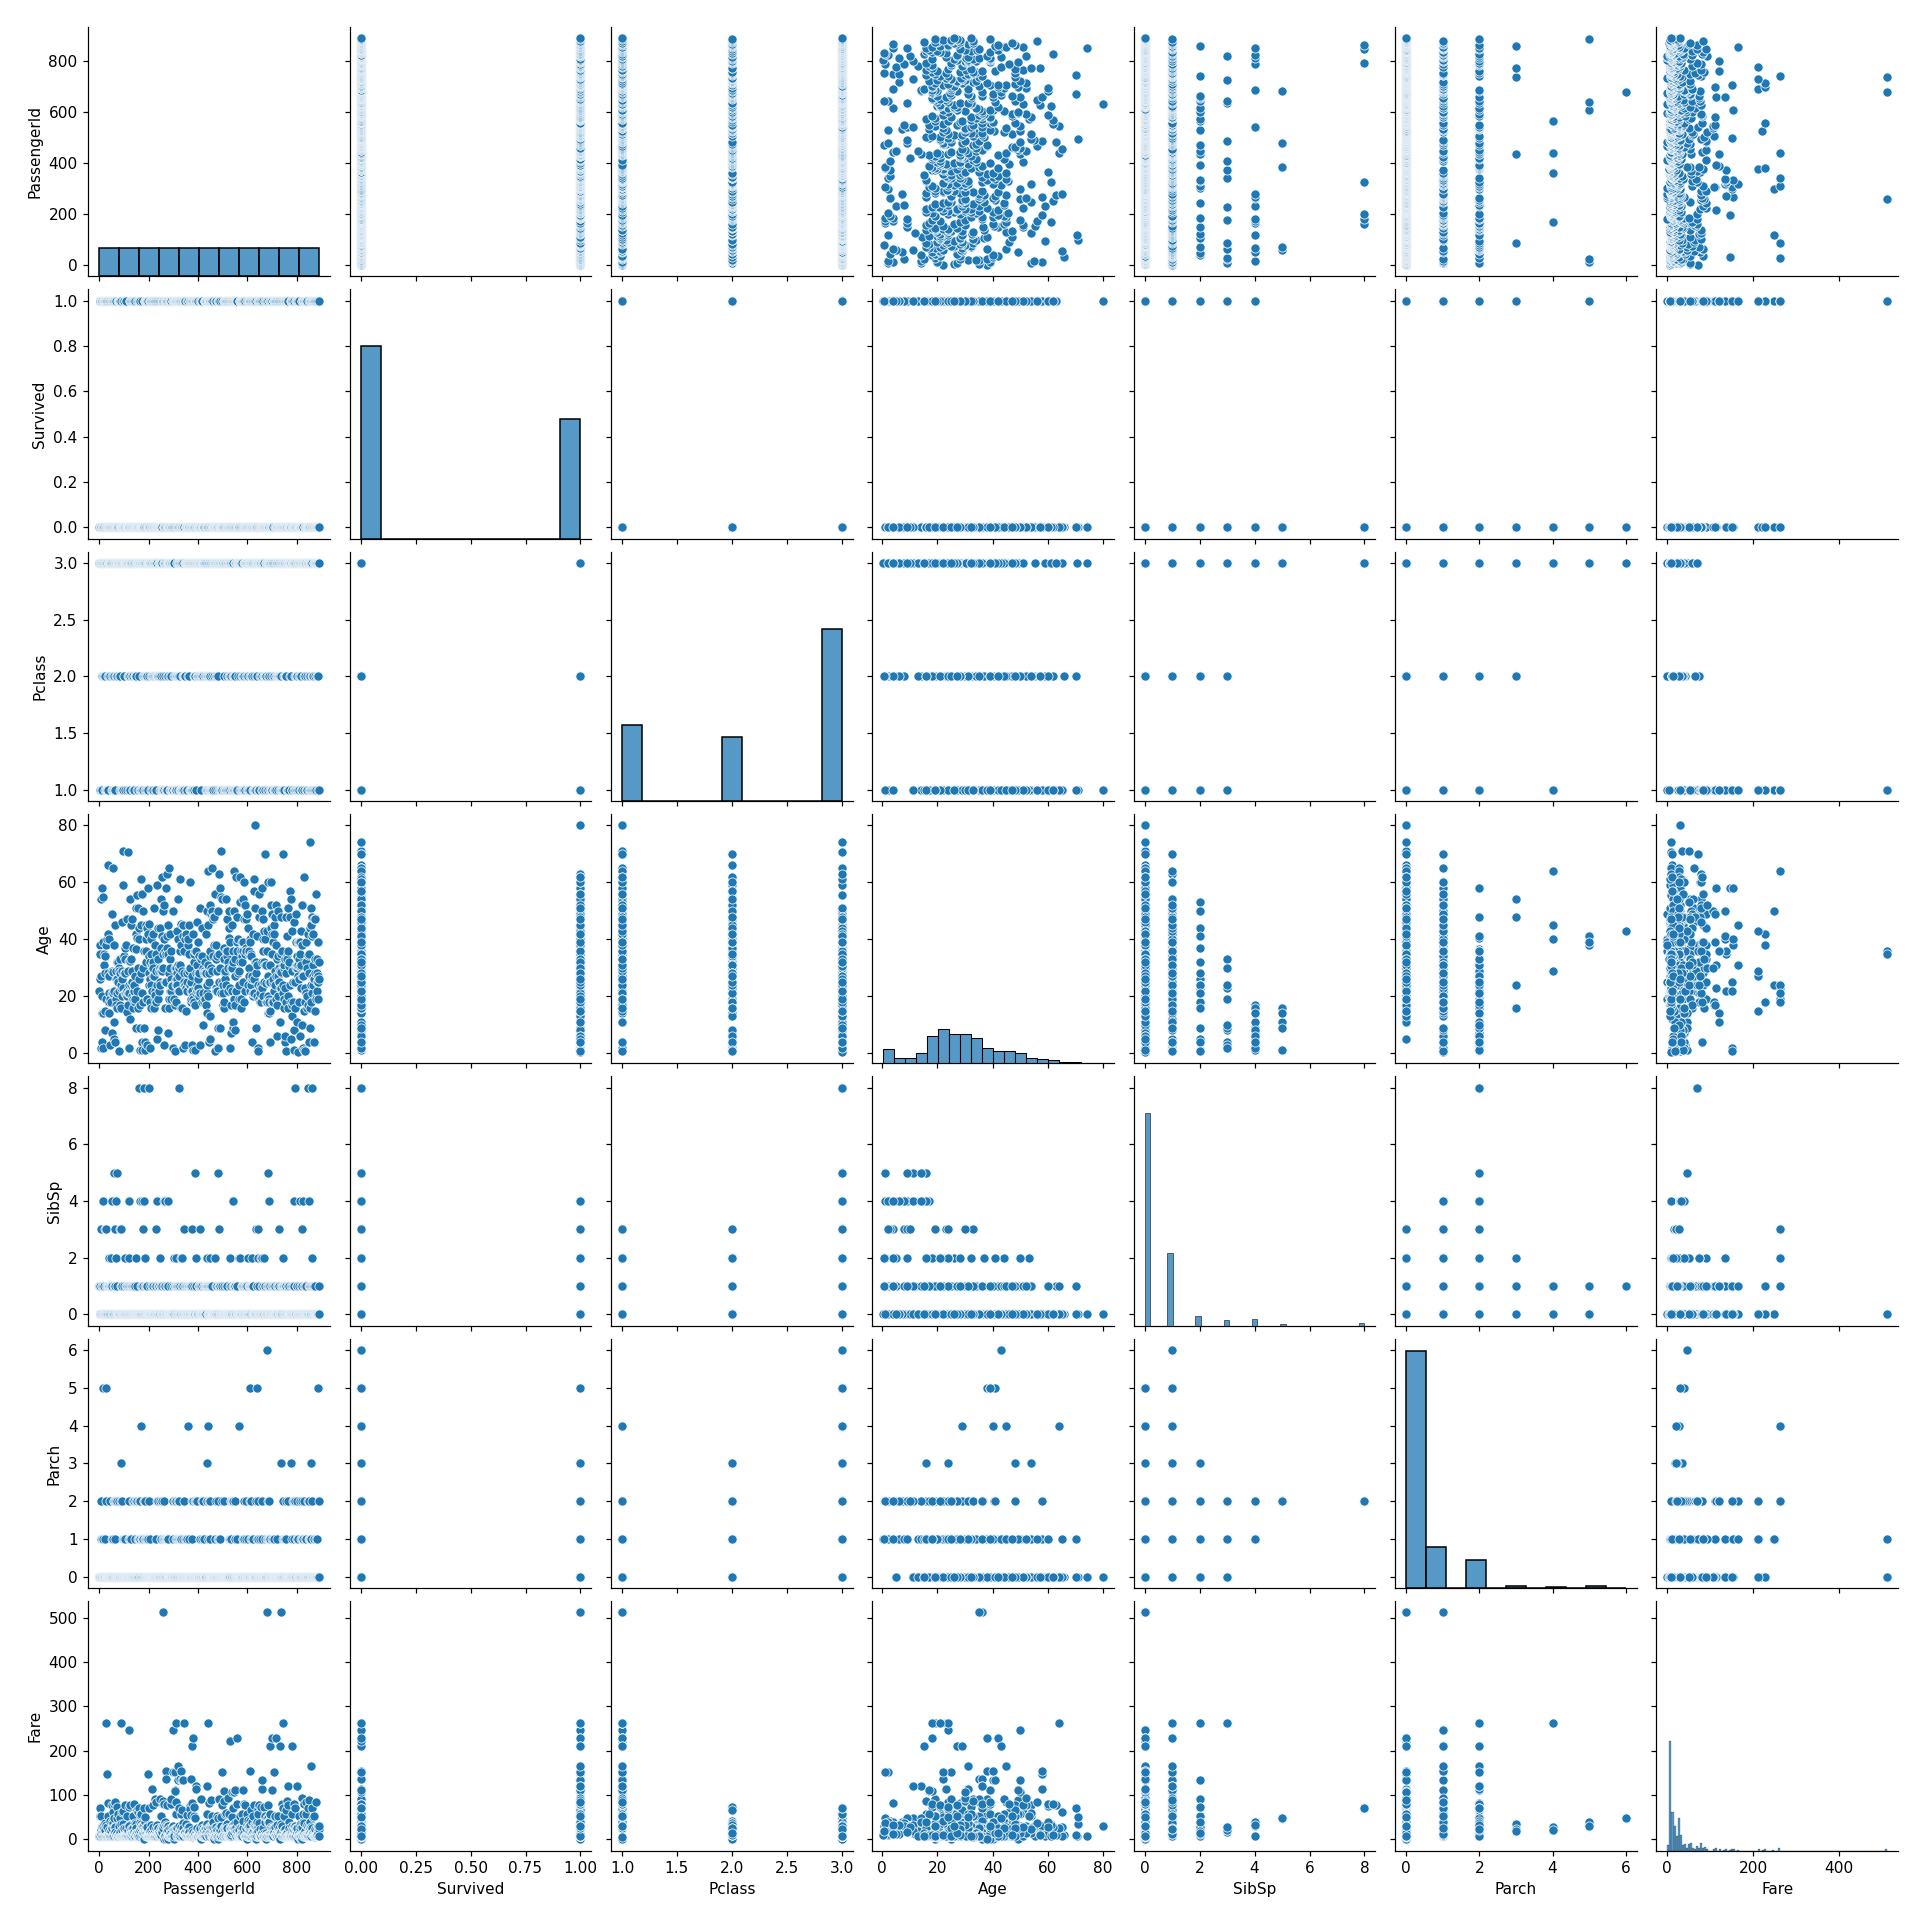

In [90]:
import seaborn as sns

relacio = sns.pairplot(dataset)

### 2. Preprocessing (normalitzation, outlier removal, feature selection..)
Un cop vistes les dades de les que es disposa, per tal de tenir un aprenentatge més eficient, es recomana normalitzar les dades i treure outliers. Segons la tipologia de dades, es poden filtrar atributs, aplicar-hi reductors de dimensionalitat, codificar categories textuals en valors numèrics..

Navegueu per la [documentació de sklearn sobre preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) per tal de trobar les diferents opcions que proporciona sklearn.

**Preguntes:**
* Estàn les dades normalitzades? Caldria fer-ho?
* En cas que les normalitzeu, quin tipus de normalització será més adient per les vostres dades?
* Teniu gaires dades sense informació? Els NaNs a pandas? Tingueu en compte que hi ha metodes que no els toleren durant el aprenentatge. Com afecta a la classificació si les filtrem? I si les reompliu? Com ho farieu? [Pista](https://scikit-learn.org/stable/modules/impute.html)
* Teniu dades categoriques? Quina seria la codificació amb més sentit? (`OrdinalEncoder`, `OneHotEncoder`, d'altres?)
* Caldria aplicar `sklearn.decomposition.PCA`? Quins beneficis o inconvenients trobarieu?
* Es poden aplicar `PolynomialFeatures` per millorar la classificació? En quins casos té sentit fer-ho?

Decidim eliminar els atributs 'PassengerId', 'Name', 'Ticket' i 'Cabin', ja que són dades amb valor únics que no aporten cap mena d'informació important al model. També observem que existeixen valos inexistents als atributs 'Age' i 'Embarked', per tant caldrà tractar aquestes files.

In [91]:
# Funcio per a llegir dades en format csv
def load_dataset(path, cols):
    dataset = pd.read_csv(path, header=0, delimiter=',', usecols=cols)
    return dataset

#Indexs de les columnes a utilitzar. Eliminem columnes 0 (PassengerId), 3 (Name), 8 (Ticket) i 10 (Cabin)
cols = list(range(12))
cols.remove(0)
cols.remove(3)
cols.remove(8)
cols.remove(10)

# Carreguem dataset
dataset = load_dataset('train.csv', cols)
data = dataset.values

x = data[:, 0]
y = data[:, 1:8]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)


Dimensionalitat de la BBDD: (891, 8)
Dimensionalitat de les entrades X (891,)
Dimensionalitat de l'atribut Y (891, 7)


L'estat actual de les nostres dades és el següent.

In [100]:
print('Valors nuls de cada atribut')
print(dataset.isnull().sum())

Valors nuls de cada atribut
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Al nostre dataset els atributs 'Sex' i 'Embarked' són atributs categòrics emmagatzemats en forma de texte. Per tal de processar-los correctament cal codificar-los en valors numèrics. La resta d'atributs són categòrics i numèrics.

In [102]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# Codifiquem l'atribut 'Sex'
data[:, 2] = le.fit_transform(data[:, 2])

# Codifiquem l'atribut 'Embarked'
data[:, 7] = le.fit_transform(data[:, 7])

Pel tractament dels valors inexistents als atributs 'Age' i 'Embarked' el que fem és omplir aquests buits amb el valor de la mitjana de cada columna.

In [109]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp_mean.fit_transform(data)